# Purpose
The purpose of this notebook is to learn how to consolidate numerical features from `data/immo_data_202208.csv` in one column each.

# Summary

| Feature       | Complete Data found in/with                                      | 
| ------------- | ---------------------------------------------------------------- |
| Living Space  | Column `Space extracted`                                         |
| Rooms         | RegEx `(\d+\.?\d?) rooms` on column `details_structured`         |
| Plot Area     | Join `Plot_area_merged` and `detail_responsive#surface_property` |
| Floor Space   | Join `Floor_space_merged` and `detail_responsive#surface_usable` |
| Floor         | Join `Floor_merged` and `detail_responsive#floor`                |
| Price         | Column `price_cleaned`                                           |
| Coordinates   | `Latitude` and `Longitude`                                       |

In [1]:
# Import modules
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Read Data
df = pd.read_csv(
    "https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/immo_data_202208.csv",
    low_memory=False,
)


# Living Space

In [this](./1-daw_columns.html) notebook we've found the following columns contain data on the living space:
- `Living space`
- `Living_space_merged`
- `Superficie abitabile`
- `Surface habitable`
- `Wohnfläche`
- `detail_responsive#surface_living`
- `description`
- `table`
- `details_structured`

In addition, the following columns also appear to contain information about the living space
- `details`
- `Space extracted`

## Subset
First we create a new dataframe containing the subset of columns relevant for the living space.

In [3]:
cols_living_space = [
    "Living space",
    "Superficie abitabile",
    "Surface habitable",
    "Wohnfläche",
    "detail_responsive#surface_living",
    "Living_space_merged",
    "Space extracted",
]
df_living_space = df.loc[:, cols_living_space]

# description
df_living_space["from_description"] = df["description"].str.extract("(\d+) m²«")

# table
df_living_space["from_table"] = df["table"].str.extract("Living space.+####>(\d+) m")


# details_structured
df_living_space["from_details_structured"] = df["details_structured"].str.extract(
    "'Living space': '(\d+) m²"
)

# details
df_living_space["from_details"] = df["details"].str.extract("(\d+) m²")


## NA Heatmap
The following heatmap shows the missing values of the selected data and can therefore give some good insight on where the complete data can be found.

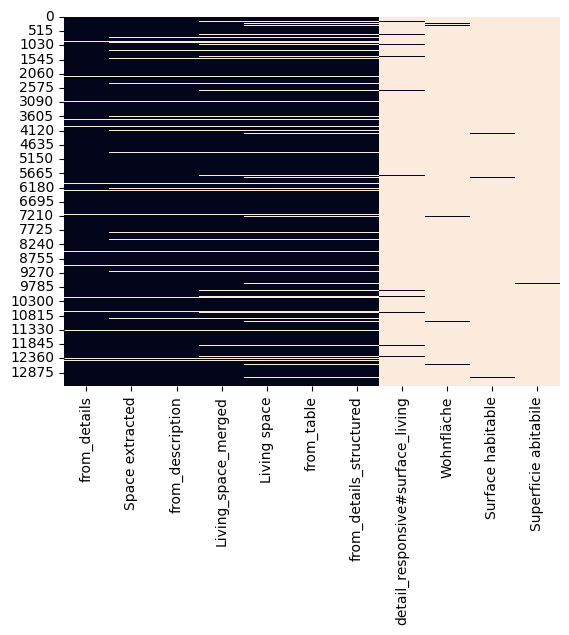

In [4]:
# Sort columns by number of non-null values
df_living_space = df_living_space.reindex(
    df_living_space.count().sort_values(ascending=False).index, axis=1
)
# Create isna heatmap
sns.heatmap(df_living_space.isna(), cbar=False)
plt.show()


It appears that `from_details` contains the most information on the living space. In the following section we analyse this in detail.

## Columns with corresponding names

First we verify that `Living_space_merged` is a combination of `Living space`, `Wohnfläche`, `Surface habitable` and `Superficie abitabile` by comparing the cumulative sum of the value counts per column against the `Living_space_merged`-count. This allows us to see if any combination of value counts adds up to the same number:

In [5]:
df_living_space[cols_living_space[0:5]].count().cumsum() == df_living_space[
    cols_living_space[5]
].count()


Living space                        False
Superficie abitabile                False
Surface habitable                   False
Wohnfläche                           True
detail_responsive#surface_living    False
dtype: bool

As we see above the cumulative sum of the values in columns `Living space`, `Wohnfläche`, `Surface habitable`, `Superficie abitabile` add up to the same amount as the `Living_space_merged` value count.  

However this does not prove that this contains the same information. We therefore investigate if the data contained in `Living_space_merged` is actually the same data contained in columns `Living space`, `Wohnfläche`, `Surface habitable` and `Superficie abitabile`.  

To do so we first combine the respective columns into one named `living_space` so we can compare the columns.

In [6]:
# Merge columns except for 'Living_space_merged' into 'living_space'
df_living_space["living_space"] = (
    df_living_space[cols_living_space[0]]
    .fillna(df_living_space[cols_living_space[1]])
    .fillna(df_living_space[cols_living_space[2]])
    .fillna(df_living_space[cols_living_space[3]])
)

# Compare 'living_space' with 'Living_space_merged'
(
    df_living_space.loc[:, "living_space"].fillna("")
    == df_living_space.loc[:, cols_living_space[5]].fillna("")
).sum() == df.shape[0]


True

Counting the `True` values of the comparison of the two columns yields the same count as the column count of the dataset meaning that all rows of the two columns are identical.

Therefore we can confirm that the column `Living_space_merged` contains all information from the columns `Living space`, `Wohnfläche`, `Surface habitable` and `Superficie abitabile`.  

What about the columns `detail_responsive#surface_living` and `Space extracted`?  

Let's check if there's any additional data in `detail_responsive#surface_living`.

In [7]:
# Display rows where 'living_space' is NaN but 'detail_responsive#surface_living' is not
display(
    df_living_space[
        df_living_space["living_space"].isna()
        & df_living_space["detail_responsive#surface_living"].notna()
    ]
)


,from_details,Space extracted,from_description,Living_space_merged,Living space,from_table,from_details_structured,detail_responsive#surface_living,Wohnfläche,Surface habitable,Superficie abitabile,living_space
2,93,93.0,93,NaN,NaN,NaN,NaN,93 m²,NaN,NaN,NaN,NaN
39,97,97.0,97,NaN,NaN,NaN,NaN,97 m²,NaN,NaN,NaN,NaN
44,216,216.0,216,NaN,NaN,NaN,NaN,216 m²,NaN,NaN,NaN,NaN
170,70,70.0,70,NaN,NaN,NaN,NaN,70 m²,NaN,NaN,NaN,NaN
178,127,127.0,127,NaN,NaN,NaN,NaN,127 m²,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13351,93,93.0,93,NaN,NaN,NaN,NaN,93 m²,NaN,NaN,NaN,NaN
13356,157,157.0,157,NaN,NaN,NaN,NaN,157 m²,NaN,NaN,NaN,NaN
13357,121,121.0,121,NaN,NaN,NaN,NaN,121 m²,NaN,NaN,NaN,NaN
13359,83,83.0,83,NaN,NaN,NaN,NaN,83 m²,NaN,NaN,NaN,NaN


This table shows that not only `detail_responsive#surface_living` but also `Space extracted`, `from_description` and `from_details` contains information on living space where the consolidated column `living_space` does not. 
Let's merge the column `detail_responsive#surface_living` into `living_space` and compare the counts again.

In [8]:
# Merge columns 'detail_responsive#surface_living' and 'Living_space_merged' into 'living_space'
df_living_space["living_space"] = df_living_space[cols_living_space[5]].fillna(
    df_living_space[cols_living_space[4]]
)

df_living_space.count()


from_details                        12777
Space extracted                     12308
from_description                    12304
Living_space_merged                 11874
Living space                        11634
from_table                          11634
from_details_structured             11634
detail_responsive#surface_living      430
Wohnfläche                            149
Surface habitable                      64
Superficie abitabile                   27
living_space                        12304
dtype: int64

The column with the most information is `from_details` with a count of 12777. But does it contain clean data? The following code will help to understand how the columns that contain direct data on the living space relate to each other.

In [9]:
# Display rows where 'living_space' is na but 'detail_responsive#surface_living' is not
display(
    df_living_space.loc[
        df["Space extracted"].notna() & df_living_space["living_space"].isna(), :
    ]
)


,from_details,Space extracted,from_description,Living_space_merged,Living space,from_table,from_details_structured,detail_responsive#surface_living,Wohnfläche,Surface habitable,Superficie abitabile,living_space
786,214,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3380,NaN,210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3696,NaN,228.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6506,NaN,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The above comparison shows where `Space extracted` has more information than the merged column `living_space`. 
But does the column `Space extracted` actually contain the same information as the merged column plus 4 more rows? To check that, the data has to be parsed the same way. 

In [10]:
# Parse 'living_space' as float
df_living_space["living_space"] = df_living_space.living_space.str.extract(
    "(\d+)"
).astype(float)

# Compare 'living_space' with 'Space extracted'
df_living_space["living_space"].dtype == df_living_space["Space extracted"].dtype


True

Now with the same datatype the data can be merged and compared once more.

In [11]:
# Fill NAs in 'living_space' with 'Space extracted'
df_living_space.fillna(df_living_space["Space extracted"], inplace=True)

# Compare 'living_space' with 'Space extracted'
(
    df_living_space["Space extracted"].astype(float).fillna(0)
    == df_living_space["living_space"].fillna(0)
).sum() == df.shape[0]


False

And with this we can see that the column `Space extracted` besides `from_detail` contains the most complete data of the investigated columns for living space so far.

In [12]:
# Set 'living_space' as 'Space extracted'
df_living_space["living_space"] = df_living_space["Space extracted"]

# Drop columns that are proven to be redundant
df_living_space.drop(
    [
        "Living space",
        "Wohnfläche",
        "Surface habitable",
        "Superficie abitabile",
        "detail_responsive#surface_living",
        "Living_space_merged",
        "Space extracted",
    ],
    axis=1,
    inplace=True,
)

df_living_space.living_space.describe()


count    12308.000000
mean       158.687195
std        120.631122
min          1.000000
25%        100.000000
50%        131.000000
75%        180.000000
max       4390.000000
Name: living_space, dtype: float64

## Raw data columns

The notebook [2-daw_raw.ipynb](./2-daw_raw.html) shows that the columns `description`, `detailed_description`, `table`, `details` and `details_structured` might contain data about the living space in a raw form. In the following section this data is explored to gain the most amount of data possible. 

### Description

In [13]:
print("description count:", df_living_space["from_description"].astype(float).count())


description count: 12304


Here we see the same count as before, when we merged all columns which names correspond with living space except `Space extracted`. Does `from_description` actually contain the same information as the merged column?

In [14]:
print(
    "Difference between living_space and from_description, where it is equal to living_space: ",
    df_living_space["living_space"].count()
    - (
        df_living_space["from_description"].astype(float)
        == df_living_space["living_space"]
    ).sum(),
)


Difference between living_space and from_description, where it is equal to living_space:  4


In [15]:
# Display rows where 'living_space' is not Na but 'from_description' is Na
display(
    df_living_space.loc[
        df_living_space["living_space"].notna()
        & df_living_space["from_description"].isna(),
        :,
    ]
)


,from_details,from_description,from_table,from_details_structured,living_space
786,214,NaN,NaN,NaN,200.0
3380,NaN,NaN,NaN,NaN,210.0
3696,NaN,NaN,NaN,NaN,228.0
6506,NaN,NaN,NaN,NaN,200.0


With this it's clear that the column `from_description` does not contain more information about the living space than `Space extracted`.

In [16]:
df_living_space.drop("from_description", axis=1, inplace=True)


### Table

In [17]:
print("table count:", df_living_space["from_table"].astype(float).count())


table count: 11634


Countwise we're well below the data we've gathered so far for the living space. 
Let's also check if there are any values for rows where `living_space` is `na`:

In [18]:
df_living_space["from_table"] = df_living_space["from_table"].astype(float)
print(
    "Count where from_table is not NA whereas living_space is: ",
    df_living_space.loc[
        df_living_space["living_space"].isna() & df_living_space["from_table"].notna(),
        "living_space",
    ].count(),
)


Count where from_table is not NA whereas living_space is:  0


This shows, that we cannot extract any more information on the living space from the `from_table` column.

In [19]:
df_living_space.drop("from_table", axis=1, inplace=True)


### Details

In [20]:
df_living_space["from_details"] = df_living_space["from_details"].astype(float)
df_living_space["from_details"].describe()


count    12777.000000
mean       185.153479
std        307.204784
min          0.000000
25%        100.000000
50%        133.000000
75%        187.000000
max       9681.000000
Name: from_details, dtype: float64

`from_details` contains more observations than `Space extracted` as we've seen. But this description shows that the max value in `from_details` is 9681 compared to 4390 in `Space extracted`. Upon manual inspection of the articles it becomes clear that the number extracted from `from_details` not always contains the `living_space` attribute but sometimes also `plot_area` or `floor_space` and since there's no keyword to classify this value, we cannot use it. 

In [21]:
df_living_space.drop("from_details", axis=1, inplace=True)


### Details_structured

In [22]:
print(
    "details_structured count:",
    df_living_space["from_details_structured"].astype(float).count(),
)


details_structured count: 11634


In [23]:
print(
    "Count where from_details_structured is not NA whereas living_space is: ",
    df_living_space.loc[
        df_living_space["living_space"].isna()
        & df_living_space["from_details_structured"].notna(),
        "living_space",
    ].count(),
)


Count where from_details_structured is not NA whereas living_space is:  0


The information on living space extracted from `details_structured` doesn't provide more information where `living_space` is `na`. Therefore it seems that the most complete data on the living space can be found in `Space extracted`.

In [24]:
df_living_space.drop("from_details_structured", axis=1, inplace=True)


In [25]:
df_living_space


,living_space
0,100.0
1,156.0
2,93.0
3,154.0
4,142.0
...,...
13373,70.0
13374,NaN
13375,150.0
13376,145.0


In [26]:
df_living_space.describe()


,living_space
count,12308.000000
mean,158.687195
std,120.631122
min,1.000000
25%,100.000000
50%,131.000000
75%,180.000000
max,4390.000000


# Rooms

We've found 4 columns containing information about rooms:
- `rooms`
- `description`
- `details`
- `details_structured`

In [27]:
cols_rooms = ["rooms"]
df_rooms = df.loc[:, cols_rooms]
df_rooms["from_description"] = (
    df["description"].str.extract("(\d+\.?\d?) rooms, ").astype(float)
)
df_rooms["from_details"] = df["details"].str.extract("(\d+\.?\d?) rooms").astype(float)
df_rooms["from_details_structured"] = (
    df["details_structured"].str.extract("(\d+\.?\d?) rooms").astype(float)
)


## NA Heatmap

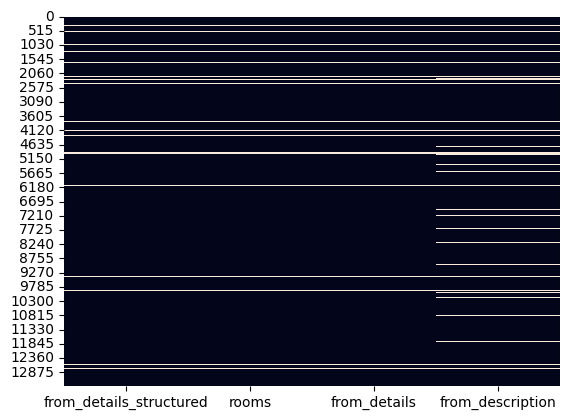

In [28]:
# Sort columns by number of non-null values
df_rooms = df_rooms.reindex(df_rooms.count().sort_values(ascending=False).index, axis=1)

# Create isna heatmap
sns.heatmap(df_rooms.isna(), cbar=False)
plt.show()


This heatmap shows that `rooms` and `from_details` as well as `from_details_structured` appear to contain the most information on the feature rooms. 

In [29]:
# Display rows where 'rooms' is na but 'from_details' is not
df_rooms.loc[
    df_rooms["from_details"].notna() & df_rooms["rooms"].isna(),
    ["from_details", "rooms"],
]


,from_details,rooms


The above statement shows that there's not more information to gather from `from_details` compared to `rooms` but what information is contained in each column?

In [30]:
df_rooms["from_details"].value_counts()


4.5     3481
3.5     2314
5.5     2186
6.5      918
2.5      849
7.5      362
5.0      343
6.0      333
7.0      298
8.0      228
4.0      222
8.5      195
3.0      173
9.0      135
10.0     125
2.0       85
11.0      85
1.5       85
12.0      66
9.5       64
10.5      42
14.0      28
13.0      23
12.5      23
11.5      21
15.0      20
20.0      13
13.5      12
14.5      11
18.0      11
16.0      11
17.0      11
21.0       5
23.0       4
19.0       4
15.5       3
17.5       3
25.0       2
16.5       2
21.5       1
22.0       1
29.0       1
Name: from_details, dtype: int64

In [31]:
df_rooms["from_details"].count()


12799

In [32]:
df_rooms["rooms"].value_counts()


5.0    10937
6.0      344
7.0      309
4.0      250
8.0      239
3.0      200
2.0      152
9.0      140
0.0      138
1.0       90
Name: rooms, dtype: int64

In [33]:
df_rooms["rooms"].count()


12799

Note that `rooms` does not contain values with `.5` but `from_details` does. In comparison `from_details` appears to contain more detailed and accurate data on the feature rooms which is why we discard the column `rooms`. 

In [34]:
df_rooms["from_details_structured"].value_counts()


4.5     3481
3.5     2315
5.5     2186
6.5      918
2.5      849
7.5      362
5.0      343
6.0      333
7.0      298
8.0      228
4.0      222
8.5      195
3.0      173
9.0      135
10.0     125
2.0       85
11.0      85
1.5       85
12.0      66
9.5       64
10.5      42
14.0      28
13.0      23
12.5      23
11.5      21
15.0      20
20.0      13
13.5      12
14.5      11
18.0      11
16.0      11
17.0      11
21.0       5
23.0       4
19.0       4
15.5       3
17.5       3
25.0       2
16.5       2
21.5       1
22.0       1
29.0       1
Name: from_details_structured, dtype: int64

In [35]:
df_rooms["from_details_structured"].count()


12800

It looks like we can gather one more observation on room from `from_details_structured` and that it's information is as detailed as `from_details`'s

In [36]:
# Display rows where 'rooms' is na but 'from_details' is not
df_rooms.loc[
    df_rooms["from_details_structured"].notna() & df_rooms["from_details"].isna(),
    ["from_details_structured", "from_details"],
]


,from_details_structured,from_details
2218,3.5,NaN


In [37]:
(df_rooms["from_details"].astype(float) == df_rooms["from_details"]).sum()


12799

In [38]:
df_rooms["rooms"] = df_rooms["from_details_structured"].astype(float)

# Drop columns that are proven to be redundant
df_rooms.drop(
    ["from_description", "from_details", "from_details_structured"],
    axis=1,
    inplace=True,
)


In [39]:
df_rooms.describe()


,rooms
count,12800.000000
mean,5.157070
std,2.211853
min,1.500000
25%,3.500000
50%,4.500000
75%,5.500000
max,29.000000


# Plot Area

We've found that the following columns contain information on plot area:
- `Grundstücksfläche`
- `Plot area`
- `Plot_area_merged`
- `Superficie del terreno`
- `Surface de terrain`
- `detail_responsive#surface_property`
- `table`
- `details_structured`

In [40]:
cols_plot_area = [
    "Plot area",
    "Grundstücksfläche",
    "Surface du terrain",
    "Superficie del terreno",
    "detail_responsive#surface_property",
    "Plot_area_merged",
]
df_plot_area = df.loc[:, cols_plot_area]
df_plot_area["from_table"] = df["table"].str.extract(
    "Plot area<\/td><td .+?####.+?####>(.+?)<"
)
df_plot_area["from_details_structured"] = df["details_structured"].str.extract(
    "'Plot area': '(\d+) m"
)


## NA Heatmap

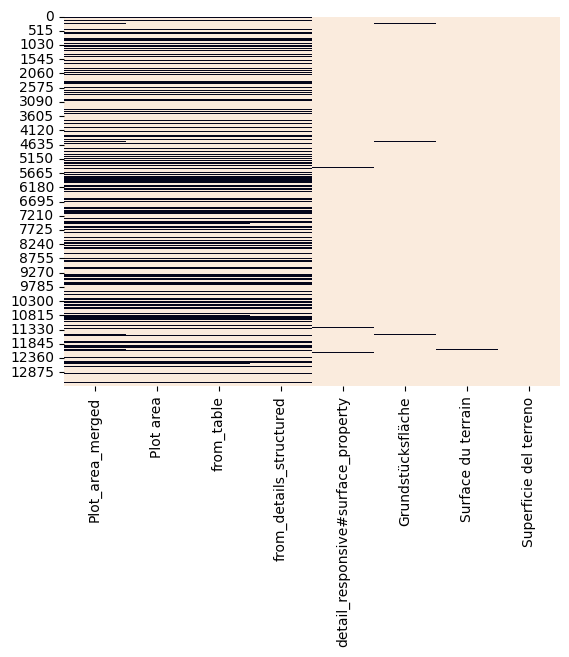

In [41]:
# Sort columns by number of non-null values
df_plot_area = df_plot_area.reindex(
    df_plot_area.count().sort_values(ascending=False).index, axis=1
)

# Create isna heatmap
sns.heatmap(df_plot_area.isna(), cbar=False)
plt.show()


Again we verify that `Plot_area_merged` is a combination of the columns with corresponding naming, except for `detail_responsive#surface_property`

In [42]:
df_plot_area[cols_plot_area[0:5]].count().cumsum() == df_plot_area[
    cols_plot_area[5]
].count()


Plot area                             False
Grundstücksfläche                     False
Surface du terrain                    False
Superficie del terreno                 True
detail_responsive#surface_property    False
dtype: bool

In [43]:
# Merge columns except for 'Plot_area_merged' into 'plot_area'
df_plot_area["plot_area"] = (
    df_plot_area[cols_plot_area[0]]
    .fillna(df_plot_area[cols_plot_area[1]])
    .fillna(df_plot_area[cols_plot_area[2]])
    .fillna(df_plot_area[cols_plot_area[3]])
)

# Compare 'plot_area' with 'Plot_area_merged'
(
    df_plot_area["plot_area"].fillna("") == df_plot_area[cols_plot_area[5]].fillna("")
).sum() == df.shape[0]


True

Let's check if there's any additional data in `detail_responsive#surface_property`.

In [44]:
# Display rows where 'plot_area' is NaN but 'detail_responsive#surface_property' is not
display(
    df_plot_area[
        df_plot_area["plot_area"].isna()
        & df_plot_area["detail_responsive#surface_property"].notna()
    ]
)


,Plot_area_merged,Plot area,from_table,from_details_structured,detail_responsive#surface_property,Grundstücksfläche,Surface du terrain,Superficie del terreno,plot_area
44,NaN,NaN,NaN,NaN,721 m²,NaN,NaN,NaN,NaN
186,NaN,NaN,NaN,NaN,259 m²,NaN,NaN,NaN,NaN
191,NaN,NaN,NaN,NaN,413 m²,NaN,NaN,NaN,NaN
240,NaN,NaN,NaN,NaN,645 m²,NaN,NaN,NaN,NaN
241,NaN,NaN,NaN,NaN,541 m²,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
12924,NaN,NaN,NaN,NaN,320 m²,NaN,NaN,NaN,NaN
13155,NaN,NaN,NaN,NaN,748 m²,NaN,NaN,NaN,NaN
13184,NaN,NaN,NaN,NaN,517 m²,NaN,NaN,NaN,NaN
13344,NaN,NaN,NaN,NaN,770 m²,NaN,NaN,NaN,NaN


This table shows that `detail_responsive#surface_property` contains information where all other columns don't.

In [45]:
# Merge columns `Plot_area_merged` and `detail_responsive#surface_property` into `plot_area`
df_plot_area["plot_area"] = df_plot_area[cols_plot_area[5]].fillna(
    df_plot_area[cols_plot_area[4]]
)


In [46]:
df_plot_area.count()


Plot_area_merged                      4794
Plot area                             4696
from_table                            4696
from_details_structured               4646
detail_responsive#surface_property     159
Grundstücksfläche                       60
Surface du terrain                      27
Superficie del terreno                  11
plot_area                             4953
dtype: int64

In [47]:
df_plot_area.drop(cols_plot_area[0:5], axis=1, inplace=True)
df_plot_area["plot_area"] = df_plot_area["plot_area"].str.extract("(\d+,?\d*)")
df_plot_area["plot_area"] = df_plot_area["plot_area"].str.replace(",", "").astype(float)
df_plot_area.plot_area.describe()


count      4953.000000
mean       1388.366243
std        7640.137598
min          20.000000
25%         341.000000
50%         612.000000
75%        1055.000000
max      350917.000000
Name: plot_area, dtype: float64

# Floor Space

We've found that the following columns contain information on floor space:
- `Floor space`
- `Floor_space_merged`
- `Nutzfläche`
- `Superficie utile`
- `Surface utile`
- `detail_responsive#surface_usable`
- `table`
- `details_structured`

In [48]:
cols_floor_space = [
    "Floor space",
    "Nutzfläche",
    "Surface utile",
    "Superficie utile",
    "detail_responsive#surface_usable",
    "Floor_space_merged",
]
df_floor_space = df.loc[:, cols_floor_space]

df_floor_space["from_table"] = df["table"].str.extract(
    "Floor space<\/td><td .+?####.+?####>(.+?)<"
)
df_floor_space["from_details_structured"] = df["details_structured"].str.extract(
    "'Floor space': '(\d+) m"
)


## NA Heatmap

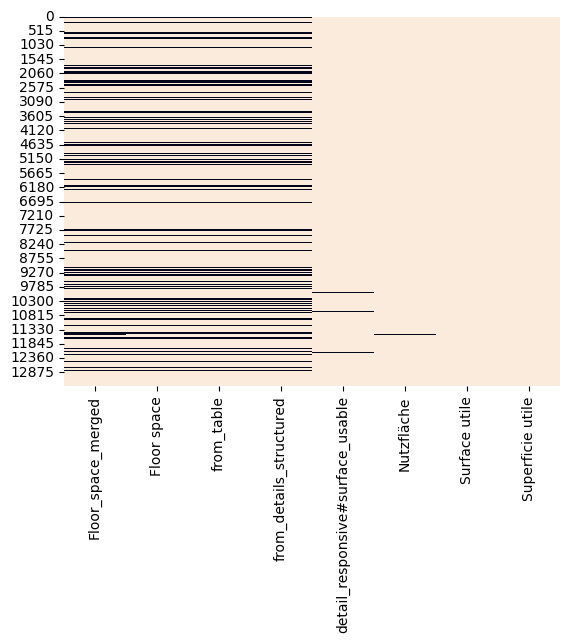

In [49]:
# Sort columns by number of non-null values
df_floor_space = df_floor_space.reindex(
    df_floor_space.count().sort_values(ascending=False).index, axis=1
)

# Create isna heatmap
sns.heatmap(df_floor_space.isna(), cbar=False)
plt.show()


Again we verify that `Floor_space_merged` is a combination of the columns with corresponding naming, except for `detail_responsive#surface_usable`

In [50]:
df_floor_space[cols_floor_space[0:5]].count().cumsum() == df_floor_space[
    cols_floor_space[5]
].count()


Floor space                         False
Nutzfläche                          False
Surface utile                       False
Superficie utile                     True
detail_responsive#surface_usable    False
dtype: bool

In [51]:
# Merge columns except for 'Floor_space_merged' into 'floor_space'
df_floor_space["floor_space"] = (
    df_floor_space[cols_floor_space[0]]
    .fillna(df_floor_space[cols_floor_space[1]])
    .fillna(df_floor_space[cols_floor_space[2]])
    .fillna(df_floor_space[cols_floor_space[3]])
)

# Compare 'floor_space' with 'Floor_space_merged'
(
    df_floor_space["floor_space"].fillna("")
    == df_floor_space[cols_floor_space[5]].fillna("")
).sum() == df.shape[0]


True

Let's check if there's any additional data in `detail_responsive#surface_usable`.

In [52]:
# Display rows where 'floor_space' is NaN but 'detail_responsive#surface_usable' is not
display(
    df_floor_space[
        df_floor_space["floor_space"].isna()
        & df_floor_space["detail_responsive#surface_usable"].notna()
    ]
)


,Floor_space_merged,Floor space,from_table,from_details_structured,detail_responsive#surface_usable,Nutzfläche,Surface utile,Superficie utile,floor_space
53,NaN,NaN,NaN,NaN,95 m²,NaN,NaN,NaN,NaN
170,NaN,NaN,NaN,NaN,101 m²,NaN,NaN,NaN,NaN
186,NaN,NaN,NaN,NaN,177 m²,NaN,NaN,NaN,NaN
335,NaN,NaN,NaN,NaN,327 m²,NaN,NaN,NaN,NaN
386,NaN,NaN,NaN,NaN,85 m²,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
12472,NaN,NaN,NaN,NaN,67 m²,NaN,NaN,NaN,NaN
12568,NaN,NaN,NaN,NaN,144 m²,NaN,NaN,NaN,NaN
12652,NaN,NaN,NaN,NaN,131 m²,NaN,NaN,NaN,NaN
12924,NaN,NaN,NaN,NaN,23 m²,NaN,NaN,NaN,NaN


This table shows that `detail_responsive#surface_usable` contains information where all other columns don't.

In [53]:
# merge columns `Floor_space_merged` and `detail_responsive#surface_usable` into `floor_space`
df_floor_space["floor_space"] = df_floor_space[cols_floor_space[5]].fillna(
    df_floor_space[cols_floor_space[4]]
)


In [54]:
df_floor_space.count()


Floor_space_merged                  2842
Floor space                         2780
from_table                          2780
from_details_structured             2780
detail_responsive#surface_usable     111
Nutzfläche                            42
Surface utile                         14
Superficie utile                       6
floor_space                         2953
dtype: int64

In [55]:
# Parsing and cleaning
df_floor_space["floor_space"] = df_floor_space.floor_space.str.extract("(\d+)").astype(
    float
)
df_floor_space.drop(
    [
        "Floor space",
        "Nutzfläche",
        "Surface utile",
        "Superficie utile",
        "detail_responsive#surface_usable",
        "Floor_space_merged",
    ],
    axis=1,
    inplace=True,
)
df_floor_space.describe()


,floor_space
count,2953.000000
mean,208.836776
std,269.952305
min,4.000000
25%,107.000000
50%,154.000000
75%,243.000000
max,7549.000000


# Floor

We've found that the following columns contain information on the floor:
- `Floor`
- `Floor_merged`
- `Piano`
- `Stockwerk`
- `Étage`
- `detail_responsive#floor`
- `table`
- `details_structured`

In [56]:
cols_floor = [
    "Floor",
    "Stockwerk",
    "Étage",
    "Piano",
    "detail_responsive#floor",
    "Floor_merged",
]
df_floor = df.loc[:, cols_floor]

df_floor["from_table"] = df["table"].str.extract("Floor<\/td><td .+?####.+?####>(.+?)<")
df_floor["from_details_structured"] = df["details_structured"].str.extract(
    "'Floor': '(.+?)'"
)


## NA Heatmap

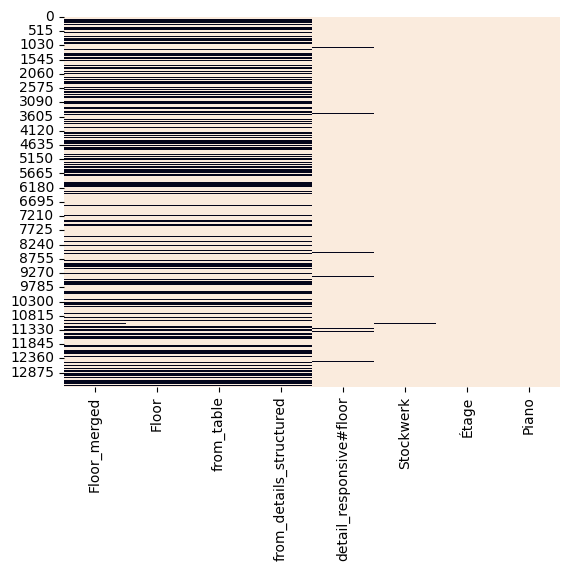

In [57]:
# Sort columns by number of non-null values
df_floor = df_floor.reindex(df_floor.count().sort_values(ascending=False).index, axis=1)

# Create isna heatmap
sns.heatmap(df_floor.isna(), cbar=False)
plt.show()


Again we verify that `Floor_merged` is a combination of the columns with corresponding naming, except for `detail_responsive#floor`

In [58]:
df_floor[cols_floor[0:5]].count().cumsum() == df_floor[cols_floor[5]].count()


Floor                      False
Stockwerk                  False
Étage                      False
Piano                       True
detail_responsive#floor    False
dtype: bool

In [59]:
# Merge columns except for 'Floor_merged' into 'floor_'
df_floor["floor"] = (
    df_floor[cols_floor[0]]
    .fillna(df_floor[cols_floor[1]])
    .fillna(df_floor[cols_floor[2]])
    .fillna(df_floor[cols_floor[3]])
)

# Compare 'floor' with 'Floor_merged'
(df_floor["floor"].fillna("") == df_floor[cols_floor[5]].fillna("")).sum() == df.shape[
    0
]


True

Let's check if there's any additional data in `detail_responsive#floor`.

In [60]:
# Display rows where 'floor_space' is NaN but 'detail_responsive#surface_usable' is not
display(
    df_floor[df_floor["floor"].isna() & df_floor["detail_responsive#floor"].notna()]
)


,Floor_merged,Floor,from_table,from_details_structured,detail_responsive#floor,Stockwerk,Étage,Piano,floor
2,NaN,NaN,NaN,NaN,2. floor,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,6. floor,NaN,NaN,NaN,NaN
53,NaN,NaN,NaN,NaN,1. floor,NaN,NaN,NaN,NaN
170,NaN,NaN,NaN,NaN,3. floor,NaN,NaN,NaN,NaN
178,NaN,NaN,NaN,NaN,3. floor,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
13349,NaN,NaN,NaN,NaN,1. floor,NaN,NaN,NaN,NaN
13351,NaN,NaN,NaN,NaN,3. floor,NaN,NaN,NaN,NaN
13356,NaN,NaN,NaN,NaN,2. floor,NaN,NaN,NaN,NaN
13359,NaN,NaN,NaN,NaN,2. floor,NaN,NaN,NaN,NaN


This table shows that `detail_responsive#floor` contains information where all other columns don't.

In [61]:
# Merge columns `Floor_merged` and `detail_responsive#floor` into `floor`
df_floor["floor"] = df_floor[cols_floor[5]].fillna(df_floor[cols_floor[4]])


In [62]:
df_floor.count()


Floor_merged               5414
Floor                      5315
from_table                 5315
from_details_structured    5306
detail_responsive#floor     206
Stockwerk                    65
Étage                        24
Piano                        10
floor                      5620
dtype: int64

In [63]:
df_floor.drop(
    [
        "Floor",
        "Stockwerk",
        "Étage",
        "Piano",
        "detail_responsive#floor",
        "Floor_merged",
        "from_table",
        "from_details_structured",
    ],
    axis=1,
    inplace=True,
)


# Price

We've found that the following columns contain information on the price:
- `price`
- `price_cleaned`
- `description`
- `details_structured`

Although the price in `details_structured` is contained in it's attribute`description`, so we assume it's equal to the information in the column `description`.

In [64]:
cols_price = ["price", "price_cleaned"]
df_price = df.loc[:, cols_price]

df_price["from_description"] = df["description"].str.extract("CHF ([\d.,]+)")


## NA Heatmap

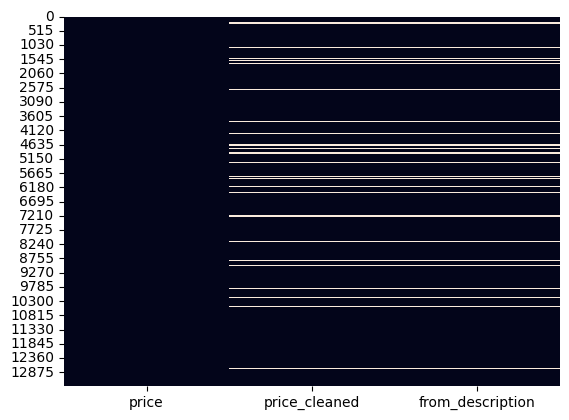

In [65]:
# Sort columns by number of non-null values
df_price = df_price.reindex(df_price.count().sort_values(ascending=False).index, axis=1)

# Create isna heatmap
sns.heatmap(df_price.isna(), cbar=False)
plt.show()


It appears that `price` contains data on every observation.

In [66]:
# Display rows where 'price' is not Na but 'price_cleaned' is
display(df_price[df_price["price_cleaned"].isna() & df_price["price"].notna()])


,price,price_cleaned,from_description
21,Price on request,NaN,NaN
41,Price on request,NaN,NaN
44,Price on request,NaN,NaN
45,Price on request,NaN,NaN
52,Price on request,NaN,NaN
...,...,...,...
13297,Price on request,NaN,NaN
13311,Price on request,NaN,NaN
13313,Price on request,NaN,NaN
13322,Price on request,NaN,NaN


But upon further inspection it becomes clear, that there are hidden NAs included. Let's parse the values in `price` and compare it to the count of `price_cleaned`

In [67]:
df_price["price"] = (
    df_price["price"]
    .str.extract("CHF ([\d,]+)")
    .replace(",", "", regex=True)
    .astype(float)
)
df_price["price"].count() - df_price["price_cleaned"].count()


-7

This shows that in fact there's less data available on the price in the column `price` than there is in `price_cleaned`.

In [68]:
df_price["from_description"] = (
    df_price["from_description"]
    .str.extract("([\d,]+)")
    .replace(",", "", regex=True)
    .astype(float)
)
df_price["from_description"].count() - df_price["price_cleaned"].count()


-3

The same goes for the price extracted from `description`. We therefore use `price_cleaned` as our target value.

In [69]:
df_price.drop(["price", "from_description"], axis=1, inplace=True)


In [70]:
df_price.describe()


,price_cleaned
count,1.236200e+04
mean,1.171045e+06
std,1.346819e+06
min,1.000000e+00
25%,5.850000e+05
50%,8.650000e+05
75%,1.318000e+06
max,4.500000e+07


# Coordinates

We've found that the following columns contain information on the coordinates:
- `lat`
- `lon`
- `Latitude`
- `Longitude`

In [71]:
cols_coord = ["lat", "lon", "Latitude", "Longitude"]
df_coord = df.loc[:, cols_coord]


In [72]:
# Get number of isnull values
df_coord.isnull().sum()


lat          17
lon          17
Latitude      0
Longitude     0
dtype: int64

In [73]:
# Get all rows with isnull values
df_coord[df_coord.isnull().any(axis=1)]


,lat,lon,Latitude,Longitude
3874,NaN,NaN,47.483776,8.766671
4096,NaN,NaN,47.483776,8.766671
4097,NaN,NaN,47.483776,8.766671
4098,NaN,NaN,47.483776,8.766671
4226,NaN,NaN,47.483776,8.766671
4229,NaN,NaN,47.483776,8.766671
4232,NaN,NaN,47.483776,8.766671
4235,NaN,NaN,47.483776,8.766671
10234,NaN,NaN,47.483776,8.766671
10237,NaN,NaN,47.483776,8.766671


With this we conclude that the columns `Latitude` and `Longitude` contain the most complete data on the coordinates.